
=== DATA AUGMENTATION ===

Processing train/fire: 723 images

Processing train/nofire: 1155 images

Processing val/fire: 152 images

Processing val/nofire: 246 images

Processing test/fire: 154 images

Processing test/nofire: 251 images

Final dataset balance:

TRAIN:
  Fire: 1155, NoFire: 1155
  Ratio: 1.00:1

VAL:
  Fire: 152, NoFire: 246
  Ratio: 0.62:1

TEST:
  Fire: 154, NoFire: 251
  Ratio: 0.61:1


FileNotFoundError: [Errno 2] No such file or directory: 'E:\\SLIIT\\Year 2 Semester 1\\IT2011 - Artficial Intelligence and Machine Learning\\Assignment\\WildFireDetection\\results\\outputs\\augmented\\eda_visualizations\\data_augmentation_visualization.png'

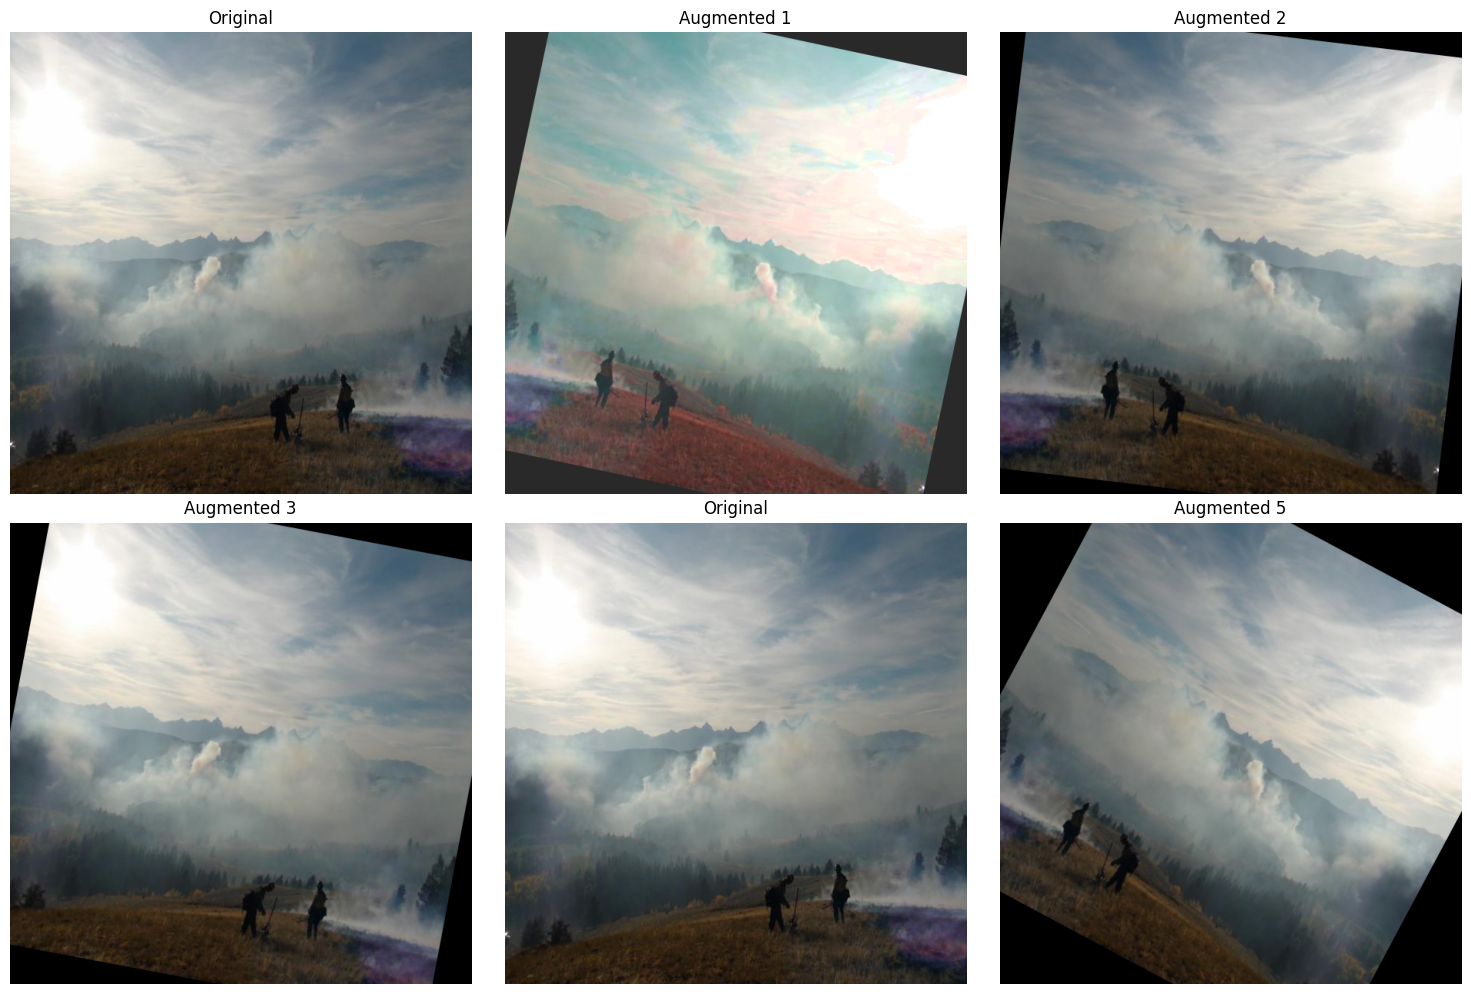

In [ ]:
import os
import albumentations as A
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm

# -----------------------------
# CONFIG
# -----------------------------
base_dir = 'E:\\SLIIT\\Year 2 Semester 1\\IT2011 - Artficial Intelligence and Machine Learning\\Assignment\\WildFireDetection\\results\\outputs\\resized'
aug_dir = 'E:\\SLIIT\\Year 2 Semester 1\\IT2011 - Artficial Intelligence and Machine Learning\\Assignment\\WildFireDetection\\results\\outputs\\augmented'
splits = ['train', 'val', 'test']
classes = ['fire', 'nofire']

# -----------------------------
# AUGMENTATION PIPELINES
# -----------------------------
fire_aug = A.Compose([
    A.Rotate(limit=30, p=0.7),
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.HueSaturationValue(p=0.5),
])

nofire_aug = A.Compose([
    A.Rotate(limit=15, p=0.3),
    A.HorizontalFlip(p=0.3),
])

# -----------------------------
# DATA AUGMENTATION
# -----------------------------
print("\n=== DATA AUGMENTATION ===")

for split in splits:
    for cls in classes:
        input_path = os.path.join(base_dir, split, cls)
        output_path = os.path.join(aug_dir, split, cls)
        os.makedirs(output_path, exist_ok=True)

        img_files = [f for f in os.listdir(input_path) if f.endswith('.jpg')]
        print(f"\nProcessing {split}/{cls}: {len(img_files)} images")

        if split == 'train':
            # Class balancing logic
            fire_count = len([f for f in os.listdir(os.path.join(base_dir, split, 'fire')) if f.endswith('.jpg')])
            nofire_count = len([f for f in os.listdir(os.path.join(base_dir, split, 'nofire')) if f.endswith('.jpg')])
            target_size = max(fire_count, nofire_count)
            needed = target_size - len(img_files)
            
            # Select augmentation pipeline
            aug_transform = fire_aug if cls == 'fire' else nofire_aug
            
            # Save originals first
            for img_name in img_files:
                img = Image.open(os.path.join(input_path, img_name)).convert("RGB")
                img.save(os.path.join(output_path, img_name))
            
            # Augment until class is balanced
            i = 0
            while i < needed:
                for img_name in img_files:
                    if i >= needed:
                        break
                    try:
                        img = Image.open(os.path.join(input_path, img_name)).convert("RGB")
                        img_np = np.array(img)
                        augmented = aug_transform(image=img_np)['image']
                        aug_img = Image.fromarray(augmented)
                        save_name = f"aug_{i}_{img_name}"
                        aug_img.save(os.path.join(output_path, save_name))
                        i += 1
                    except Exception as e:
                        tqdm.write(f"⚠️ Error processing {img_name}: {e}")
        else:
            # For val/test just copy images
            for img_name in img_files:
                try:
                    img = Image.open(os.path.join(input_path, img_name)).convert("RGB")
                    img.save(os.path.join(output_path, img_name))
                except Exception as e:
                    tqdm.write(f"⚠️ Error processing {img_name}: {e}")

# -----------------------------
# CHECK BALANCE
# -----------------------------
print(f"\nFinal dataset balance:")

for split in splits:
    fire_path = os.path.join(aug_dir, split, 'fire')
    nofire_path = os.path.join(aug_dir, split, 'nofire')

    fire_count = len([f for f in os.listdir(fire_path) if f.endswith('.jpg')])
    nofire_count = len([f for f in os.listdir(nofire_path) if f.endswith('.jpg')])

    print(f"\n{split.upper()}:")
    print(f"  Fire: {fire_count}, NoFire: {nofire_count}")
    ratio = fire_count / nofire_count if nofire_count > 0 else 0
    print(f"  Ratio: {ratio:.2f}:1")

# -----------------------------
# VISUALIZE
# -----------------------------
sample_path = os.path.join(base_dir, 'train', 'fire')
img_files = [f for f in os.listdir(sample_path) if f.endswith('.jpg')]

if img_files:
    img = np.array(Image.open(os.path.join(sample_path, img_files[0])).convert("RGB"))

    augmented = [fire_aug(image=img)['image'] for _ in range(4)]

    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    for i, ax in enumerate(axes.flat):
        if i == 0 or i == 4:
            ax.imshow(img)
            ax.set_title('Original')
        else:
            ax.imshow(augmented[i-1 if i < 4 else i-2])
            ax.set_title(f'Augmented {i}')
        ax.axis('off')

    plt.tight_layout()
    plt.show()